In [1]:
files = !ls
if 'food-101' not in files:
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    !tar xzvf food-101.tar.gz

In [2]:
import tensorflow as tf

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import os
from glob import glob
from time import time
from itertools import chain
from pprint import pprint

from tqdm.keras import TqdmCallback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, ResNet50V2, 
    MobileNet, MobileNetV2, 
    EfficientNetB0, EfficientNetB1, EfficientNetB2,
    InceptionV3	, InceptionResNetV2,
)
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from sklearn.metrics import confusion_matrix, classification_report
import mlflow
import mlflow.tensorflow
import mlflow.keras

mlflow.set_tracking_uri("sqlite:///ml_training_logs/mlflow.db")
mlflow.set_experiment("LiveProjectDeployCViOS")

np.random.seed(42)

foods = !ls food-101/images
foods = np.random.choice(foods, size=5, replace=False)


paths = [glob(f"food-101/images/{food}/*") for food in foods]
              
X = np.ravel([p for p in chain(paths)])
y = np.ravel([[i]*1000 for i in range(len(foods))])
food_label = np.ravel([[food]*1000 for food in foods])

set_type = np.random.choice(['train','test','validation'], len(X), replace=True, p=[0.7, 0.2, 0.1])

data_df = pd.DataFrame({'X':X, 'y':y, 'set':set_type, 'food_label':food_label})
data_df = pd.concat([data_df, pd.get_dummies(data_df['food_label'])], axis=1)

data_df

,X,y,set,food_label,frozen_yogurt,hot_dog,nachos,omelette,risotto
0,food-101/images/risotto/65321.jpg,0,train,risotto,0,0,0,0,1
1,food-101/images/risotto/200595.jpg,0,test,risotto,0,0,0,0,1
2,food-101/images/risotto/19112.jpg,0,test,risotto,0,0,0,0,1
3,food-101/images/risotto/94799.jpg,0,train,risotto,0,0,0,0,1
4,food-101/images/risotto/111461.jpg,0,validation,risotto,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
4995,food-101/images/frozen_yogurt/1283999.jpg,4,train,frozen_yogurt,1,0,0,0,0
4996,food-101/images/frozen_yogurt/610008.jpg,4,train,frozen_yogurt,1,0,0,0,0
4997,food-101/images/frozen_yogurt/2177517.jpg,4,train,frozen_yogurt,1,0,0,0,0
4998,food-101/images/frozen_yogurt/3802650.jpg,4,train,frozen_yogurt,1,0,0,0,0


In [4]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)

In [5]:
target_shape = (160, 160)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255
    )


train_generator = datagen.flow_from_dataframe(
    data_df[data_df['set'] == 'train'],
    x_col='X',
    y_col='food_label',
    directory=None,
    target_size=(target_shape),
    class_mode='sparse',
    batch_size=32,
    Interpolation='bicubic',
)

test_generator = datagen.flow_from_dataframe(
    data_df[data_df['set'] == 'test'],
    x_col='X',
    y_col='food_label',
    directory=None,
    target_size=(target_shape),
    class_mode='sparse',
    batch_size=32,
    Interpolation='bicubic',
    shuffle=False,
)

val_generator = datagen.flow_from_dataframe(
    data_df[data_df['set'] == 'validation'],
    x_col='X',
    y_col='food_label',
    directory=None,
    target_size=(target_shape),
    class_mode='sparse',
    batch_size=32,
    Interpolation='bicubic',
)

Found 3499 validated image filenames belonging to 5 classes.
Found 1036 validated image filenames belonging to 5 classes.
Found 465 validated image filenames belonging to 5 classes.


In [6]:
base_models = [
    ResNet50, ResNet50V2, 
    MobileNet, MobileNetV2, 
    EfficientNetB0, EfficientNetB1, EfficientNetB2,
    InceptionV3	, InceptionResNetV2,
]

    
def run(
    base, 
    initial_learning_rate=1e-3, 
    decay_steps=50, 
    decay_rate=0.95,
    steps_per_epoch=10,
    epochs=50,
    validation_steps=5,
):
    params = {}
    params['foods'] = foods
    params['base_model'] = base.__name__
    params['initial_learning_rate'] = initial_learning_rate
    params['decay_steps'] = decay_steps
    params['decay_rate'] = decay_rate
    
    pprint(params)
    
    conv_base = base(weights='imagenet', include_top=False, input_shape=[*target_shape, 3])
    conv_base.trainable = False
    
    with mlflow.start_run() as run:
        model = models.Sequential()
        model.add(conv_base)
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(len(foods), activation='softmax'))

        loss_fn = losses.SparseCategoricalCrossentropy(from_logits=False)
        
        lr_schedule = ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
        )
        
        optimizer = Adam(learning_rate=lr_schedule)

        model.compile(loss=loss_fn,
                      optimizer=optimizer,
                      metrics=['acc','mse'])

        time_callback = TimeHistory()

        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_steps=validation_steps,
            validation_data=val_generator,
            callbacks=[TqdmCallback(), time_callback],
            verbose=0,
        )
        
        model.save('model.h5')
        num_trainable = sum([np.prod(tw.shape) for tw in model.trainable_weights])
        num_non_trainable = sum([np.prod(tw.shape) for tw in model.non_trainable_weights])
        total_wall_time = sum(time_callback.times)
        model_size = os.stat('model.h5').st_size / (1024**2)

        params['num_trainable'] = num_trainable
        params['num_non_trainable'] = num_non_trainable
        params['total_wall_time'] = total_wall_time
        params['model_size'] = model_size
        mlflow.log_params(params)
        

        y_pred = model.predict(test_generator)
        y_pred_food = np.argmax(y_pred, axis=1)
        test_acc = np.mean(np.array(test_generator.classes) == y_pred_food)
        mlflow.log_metric('test_acc', test_acc)
        if test_acc > 0.85:
            mlflow.keras.log_model(model, 'model')

        sns.heatmap(confusion_matrix(test_generator.classes, y_pred_food), annot=True, fmt="d")

        fig, ax = plt.subplots(1,3, figsize=(18,6))

        hist_df = pd.DataFrame(history.history).reset_index()
        try:
            hist_df.plot(y=['loss','val_loss'], ax=ax[0])
            hist_df.plot(y=['acc','val_acc'], ax=ax[1])
            hist_df.plot(y=['mse','val_mse'], ax=ax[2])
        except:
            hist_df.plot(y=['loss'], ax=ax[0])
            hist_df.plot(y=['acc'], ax=ax[1])
            hist_df.plot(y=['mse'], ax=ax[2])
            
        
        ax[1].axhline(test_acc, color='r', linestyle='--', label='test_acc')
        
        plt.savefig('acc_loss.png')
        plt.clf()

        plt.savefig('confusion_matrix.png')
        plt.clf()
         
        mlflow.log_artifact('acc_loss.png', artifact_path="plots")
        mlflow.log_artifact('confusion_matrix.png', artifact_path="plots")
        
        for idx, row in hist_df.iloc[1:,].iterrows():
            mlflow.log_metrics(row.to_dict(), step=idx)
        params['hist_df'] = hist_df
        return params

{'base_model': 'ResNet50',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}



{'base_model': 'ResNet50V2',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}



{'base_model': 'MobileNet',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}



{'base_model': 'MobileNetV2',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}



{'base_model': 'EfficientNetB0',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}



{'base_model': 'EfficientNetB1',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}



{'base_model': 'EfficientNetB2',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}



{'base_model': 'InceptionV3',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}
87916544/87910968 [==============================] - 34s 0us/step



{'base_model': 'InceptionResNetV2',
 'decay_rate': 0.95,
 'decay_steps': 50,
 'foods': array(['risotto', 'hot_dog', 'nachos', 'omelette', 'frozen_yogurt'],
      dtype='<U23'),
 'initial_learning_rate': 0.001}
219062272/219055592 [==============================] - 73s 0us/step


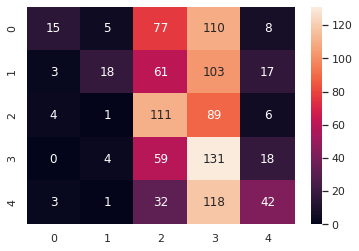

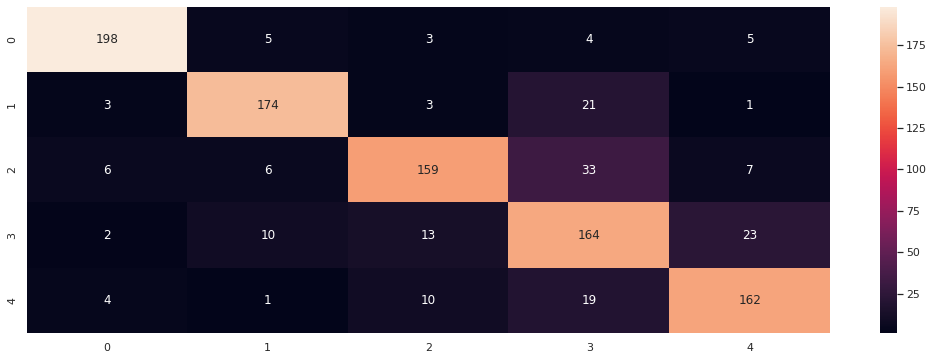

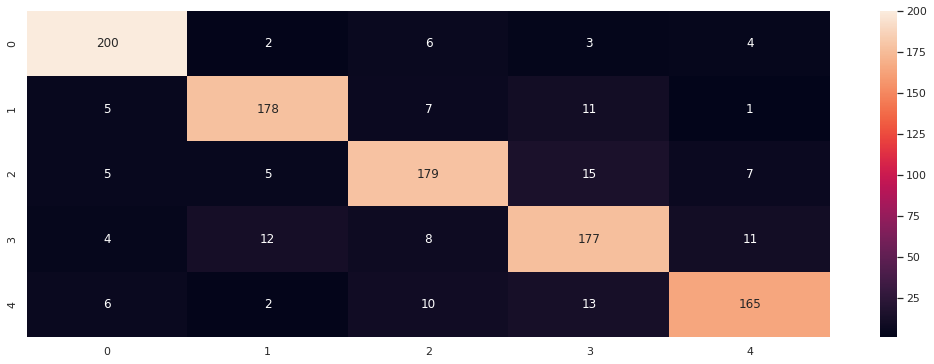

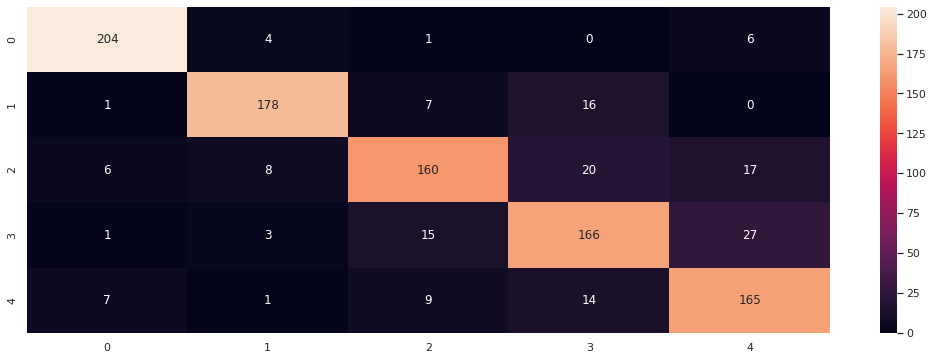

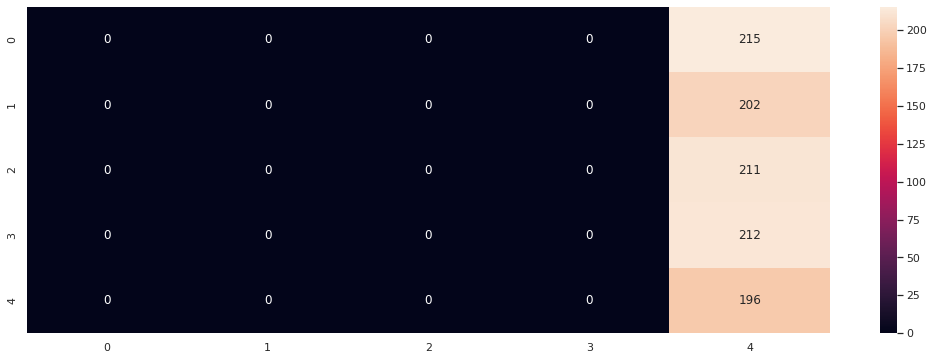

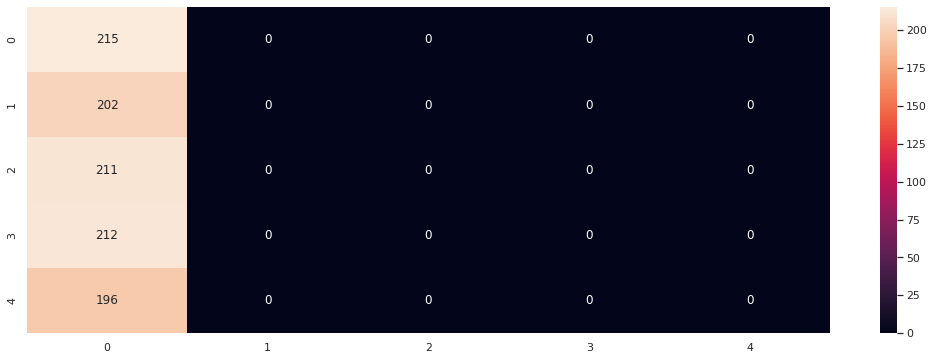

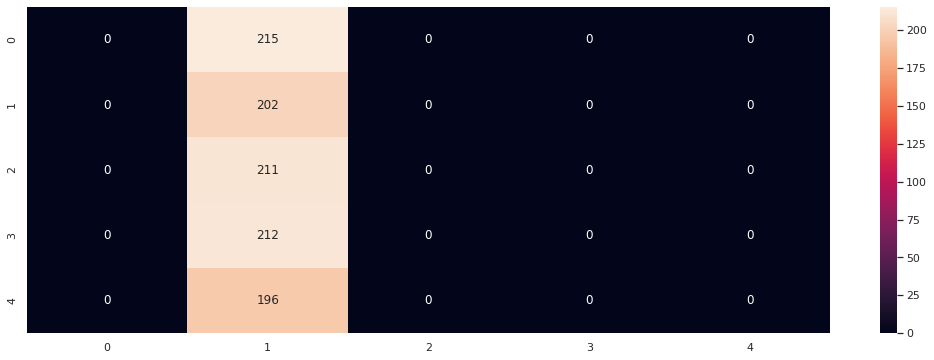

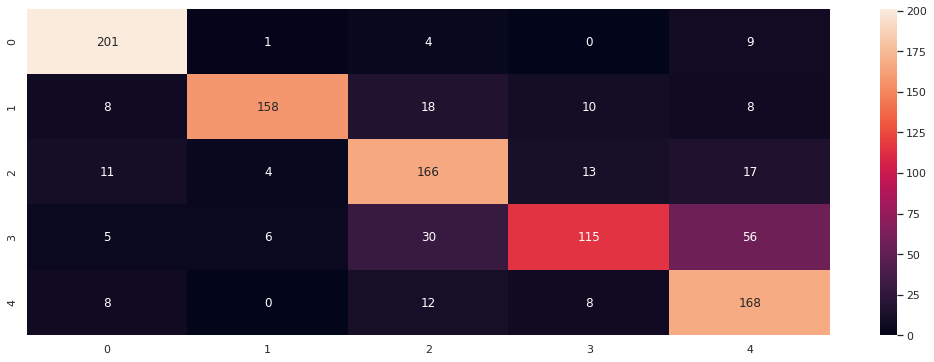

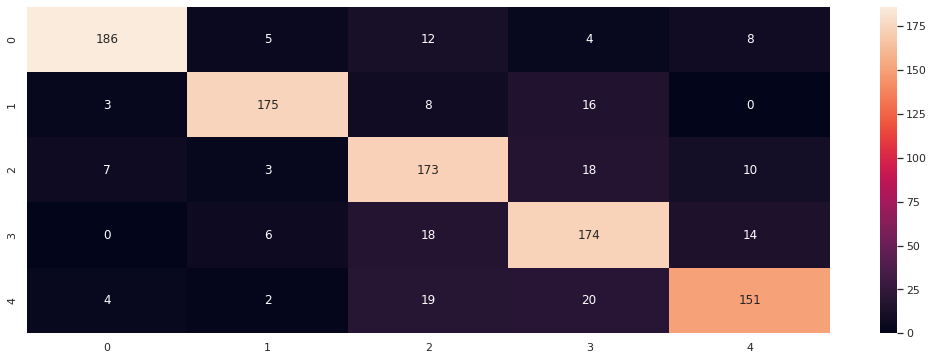

<Figure size 1296x432 with 0 Axes>

In [7]:
results = []

for base in base_models:
    params = run(base)
    results.append(params)

In [16]:
final_table = []
for r in results:
    final_table.append([
        r['base_model'],
        r['num_trainable'],
        r['num_non_trainable'],
        r['total_wall_time'],
        r['hist_df']['acc'].iloc[-1] * 100,
        r['hist_df']['index'].iloc[-1],
        r['model_size'],
    ])

In [17]:
pd.DataFrame(
    final_table, 
    columns=[
        'Base Model',
        'Trainable Params',
        'Non-Trainable Params',
        'Time',
        'Train Accuracy',
        'Epochs',
        'Model Size',
    ])

,Base Model,Trainable Params,Non-Trainable Params,Time,Train Accuracy,Epochs,Model Size
0,ResNet50,262917,23587712.0,146.691109,34.375000,49,93.306076
1,ResNet50V2,262917,23564800.0,144.952428,92.976588,49,93.204933
2,MobileNet,131845,3228864.0,141.465317,91.562498,49,13.991608
3,MobileNetV2,164613,2257984.0,142.051649,92.500001,49,10.793533
4,EfficientNetB0,164613,4049571.0,145.259782,17.187500,49,17.707634
5,EfficientNetB1,164613,6575239.0,148.467115,20.000000,49,27.486427
6,EfficientNetB2,180997,7768569.0,148.776566,19.062500,49,32.225670
7,InceptionV3,262917,21802784.0,145.538583,80.312502,49,86.667542
8,InceptionResNetV2,197381,54336736.0,153.501298,86.562502,49,210.692360
